In [1]:
from omegaconf import OmegaConf
import sys
sys.path.append('../')
from utils.brainToText_trainDecoder import brainToText_decoder

args = OmegaConf.load('T17_trainArgs_subs.yaml')

decoder = brainToText_decoder(args)
out, out_by_day = decoder.inference()

2025-04-07 17:09:42.818278: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 17:09:42.839124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 17:09:42.839138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 17:09:42.839155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 17:09:42.843670: I tensorflow/core/platform/cpu_feature_g

2025-04-07 17:09:43,787: Using GPU #: 0


2025-04-07 17:09:43.793273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-07 17:09:43.832103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-07 17:09:43.832249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  12585984  
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 gru_3 (GRU)                 multiple                  1575936   
                                                                 
 gru_4 (GRU)                 multiple                  1575936   
                                                                 
 gru_5 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  15903     
                                                                 
Total params: 18906143 (72.12 MB)
Trainable params: 18906143 (7

2025-04-07 17:09:46.421347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


2025-04-07 17:09:46,794: Val batch: CER (t17.2024.06.03): 0.287


In [2]:
import re
import numpy as np
DECODE_CHAR_DEF = ['>', ',', '?', '.',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 
    'H', 'I', 'J', 'K', 'L', 'M', 'N', 
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
    'V', 'W', 'X', 'Y', 'Z']

def remove_punctuation(sentence):
    # Remove punctuation
    sentence = re.sub(r'[^a-zA-Z?.,\- \']', '', sentence)
    sentence = sentence.replace('--', '').lower()
    sentence = sentence.replace("'", "").lower()
    sentence = sentence.strip()

    return sentence
def _ascii_to_text(text):
    endIdx = np.argwhere(text==0)
    out_txt = ''.join([chr(char) for char in text[0:endIdx[0,0]]])
    return ' '.join(out_txt.split())


def ctc_to_char(decoded):
    output = []
    for c in decoded:
        if c < len(DECODE_CHAR_DEF) and c != -1:
            letter = DECODE_CHAR_DEF[c]
            if letter == '>':
                output.append(' ')
            else:
                output.append(letter)
    return ''.join(output)
    
trueTranscriptions = []
decodedTranscriptions = []
for i in range(len(out['transcriptions'])):
    trueTranscriptions.append(_ascii_to_text(out['transcriptions'][i]))
    decodedTranscriptions.append(ctc_to_char(out['decodedSeqs'][i]))

for x in range(len(trueTranscriptions)):
    trueTranscriptions[x] = remove_punctuation(trueTranscriptions[x])
    decodedTranscriptions[x] = remove_punctuation(decodedTranscriptions[x])

In [3]:
from edit_distance import SequenceMatcher
import matplotlib.pyplot as plt
import numpy as np
SIL_DEF = ['>']
CHAR_DEF = [',', '?', '.',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 
    'H', 'I', 'J', 'K', 'L', 'M', 'N', 
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
    'V', 'W', 'X', 'Y', 'Z']

CHAR_DEF_WITH_SIL = ['>']
CHAR_DEF_WITH_SIL.extend(CHAR_DEF)

ORIGINAL_CHAR_DEF = ['>', ',', '?', '.',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 
    'H', 'I', 'J', 'K', 'L', 'M', 'N', 
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
    'V', 'W', 'X', 'Y', 'Z']
NEW_CHAR_ORDER = ['Q', 'A', 'Z', 
                   'W', 'S', 'X', 
                   'E', 'D', 'C', 
                   'R', 'F', 'V', 
                   'T', 'G', 'B', 
                   'Y', 'H', '>', 
                   'U', 'J', 'N',
                   'I', 'K', 'M',
                   'O', 'L', ',',
                   'P', '?', '.',
                  ]



def sentenceToCharacters(thisTranscription):
    # Remove punctuation
    thisTranscription = re.sub(r'[^a-zA-Z?.,\- \']', '', thisTranscription)
    thisTranscription = thisTranscription.replace('--', '').lower()
    
    characters = []
    if len(thisTranscription) == 0:
        characters = '>'
    else:
        for c_iter, c in enumerate(list(thisTranscription.upper())):
            if c == ' ':
                characters.append('>')

            c = re.sub(r'[0-9]', '', c)  # Remove stress
            if c in CHAR_DEF:  # Only keep letters and punctuation
                characters.append(c)

    return characters, thisTranscription


reorderIdx = []
for x in range(len(NEW_CHAR_ORDER)):
    for y in range(len(ORIGINAL_CHAR_DEF)):
        if NEW_CHAR_ORDER[x]==ORIGINAL_CHAR_DEF[y]:
            break
    reorderIdx.append(y)
reorderIdx = np.array(reorderIdx).astype(np.int32)

substitutions = {p: {pp: 0 for pp in CHAR_DEF_WITH_SIL} for p in CHAR_DEF_WITH_SIL}
total_edit_distance = 0
total_substitutions = 0
total_seq_length = 0

for i in range(len(trueTranscriptions)):
    trueSeq = sentenceToCharacters(trueTranscriptions[i])[0]
    decodeSeq = sentenceToCharacters(decodedTranscriptions[i])[0]

    matcher = SequenceMatcher(a=trueSeq, b=decodeSeq)
    total_edit_distance += matcher.distance()
    total_seq_length += len(trueSeq)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            substitutions[trueSeq[i1:i2][0]][decodeSeq[j1:j2][0]] += 1
            total_substitutions += 1

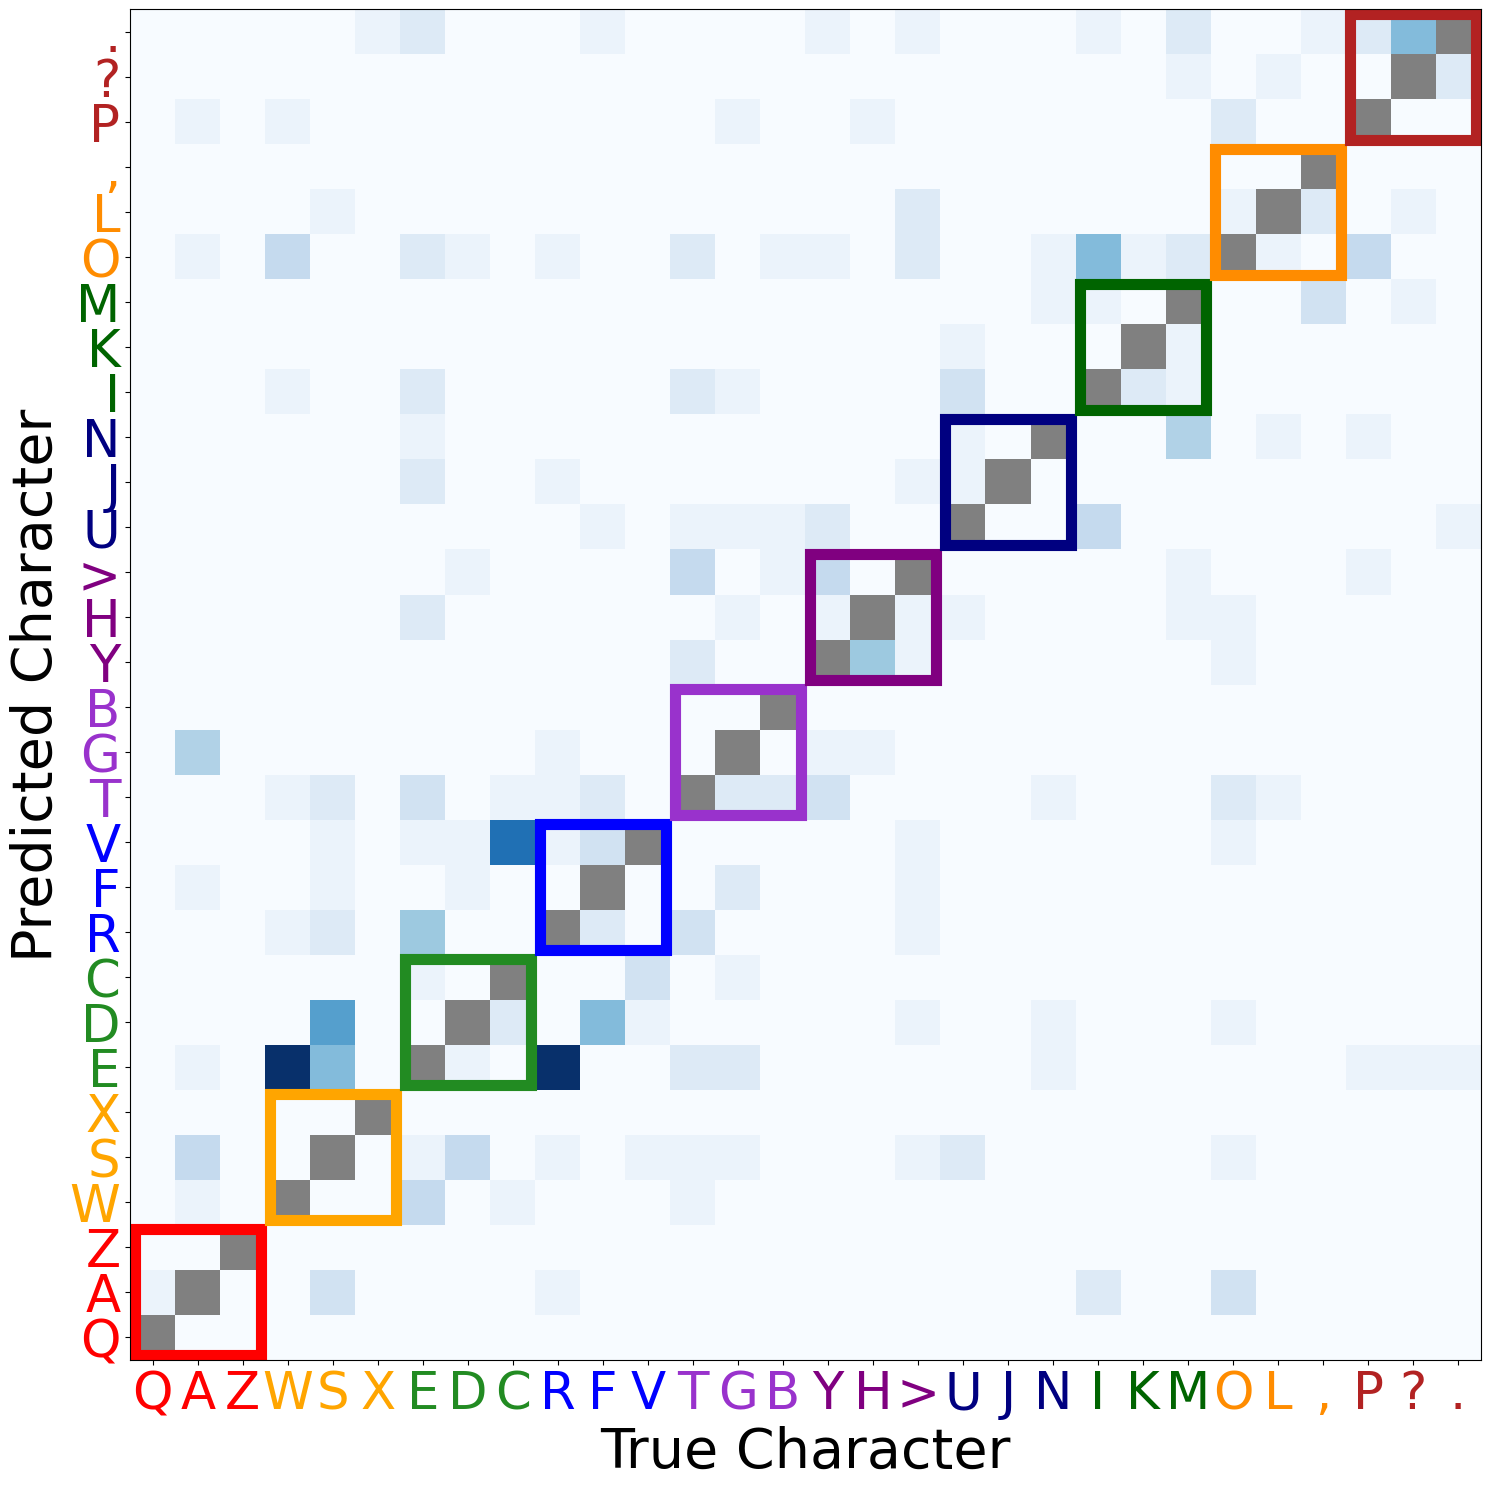

In [6]:


cMat = np.zeros([len(CHAR_DEF_WITH_SIL), len(CHAR_DEF_WITH_SIL)])
for x in range(len(CHAR_DEF_WITH_SIL)):
    for y in range(len(CHAR_DEF_WITH_SIL)):
        cMat[x,y] = substitutions[CHAR_DEF_WITH_SIL[x]][CHAR_DEF_WITH_SIL[y]]
        if x == y:
            cMat[x,y] =-1

cMat = cMat[reorderIdx,:]
cMat = cMat[:,reorderIdx]


from matplotlib import cm as cm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


cMat = np.ma.masked_where(cMat == -1, cMat)
cmap = matplotlib.cm.Blues
cmap.set_bad(color='gray')

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
plt.imshow(cMat.T, clim=[0,18],cmap=cmap)
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(0,cMat.shape[0]), labels=NEW_CHAR_ORDER, rotation=0, fontsize=37)
plt.yticks(ticks=np.arange(0,cMat.shape[0]), labels=NEW_CHAR_ORDER, fontsize=37)
plt.xlabel('True Character', fontsize=40)
plt.ylabel('Predicted Character', fontsize=40)
colors = ['red', 'orange', 'forestgreen','b', 'darkorchid','purple', 'navy', 'darkgreen', 'darkorange', 'firebrick']
for finger in range(10):
    ax.add_patch(
         patches.Rectangle(
            xy=(-0.4 + finger*3, -0.4 + finger*3),  # point of origin.
            width=3-0.2, height=3-0.2, linewidth=8,
            color=colors[finger], fill=False))
    for flexion in range(3):
        ax.get_xticklabels()[finger*3 + flexion].set_color(colors[finger])
        ax.get_yticklabels()[finger*3 + flexion].set_color(colors[finger])
plt.tight_layout()
plt.savefig('T17LMCompSubs.svg', bbox_inches='tight')